<a href="https://colab.research.google.com/github/chrissyhroberts/jupyter_notebooks_random/blob/main/Image_to_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image to Image AI

Takes an input image and a mask file
Give it a prompt and it will draw something.
Saves to a file

In [1]:
pip install diffusers transformers accelerate


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 65.9 MB/s eta 0:00:00
  Created wheel for diffusers: filename=diffusers-0.21.2-py3-none-any.whl size=1489250 sha256=75c2e916ef8d7690cdfbcf443cf13259ce2af0391d9dcf4922875bb05b4b5459
  Stored in directory: /root/.cache/pip/wheels/2e/09/32/11c9e42c397d3f3494226b28ba68c4ad4718a68a65dba14ea6
Successfully built diffusers


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
# !pip install transformers accelerate
from diffusers import StableDiffusionControlNetInpaintPipeline, ControlNetModel
from diffusers.utils import load_image
import numpy as np
import torch

In [10]:
def make_inpaint_condition(image, image_mask):
    image = np.array(image.convert("RGB")).astype(np.float32) / 255.0
    image_mask = np.array(image_mask.convert("L")).astype(np.float32) / 255.0

    assert image.shape[0:1] == image_mask.shape[0:1], "image and image_mask must have the same image size"
    image[image_mask > 0.5] = -1.0  # set as masked pixel
    image = np.expand_dims(image, 0).transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return image

In [12]:
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/control_v11p_sd15_inpaint", torch_dtype=torch.float16
)
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
)

pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [105]:
def generate_and_save_image(pipeline, prompt, output_file, num_steps, generator, eta, init_image_file, mask_image_file, image_size):
    # Load and resize the initial image
    init_image = load_image(init_image_file)
    init_image = init_image.resize(image_size)

    # Load and resize the mask image
    mask_image = load_image(mask_image_file)
    mask_image = mask_image.resize(image_size)

    # Create the control image
    control_image = make_inpaint_condition(init_image, mask_image)

    # Generate the image using the provided parameters
    image = pipeline(
        prompt,
        num_inference_steps=num_steps,
        generator=generator,
        eta=eta,
        image=init_image,
        mask_image=mask_image,
        control_image=control_image,
    ).images[0]

    # Convert the image to a NumPy array
    generated_image_np = np.array(image)

    # Invert the pixel values
    generated_image_np = 1.0 - generated_image_np

    # Create a PIL Image object from the NumPy array
    generated_image_pil = Image.fromarray((generated_image_np * 255).astype('uint8'))

    # Display the image in the notebook
    plt.imshow(generated_image_pil)
    plt.axis('off')  # Turn off axis labels
    plt.show()

    # Save the image to a file with the specified name
    generated_image_pil.save(output_file)


  0%|          | 0/20 [00:00<?, ?it/s]

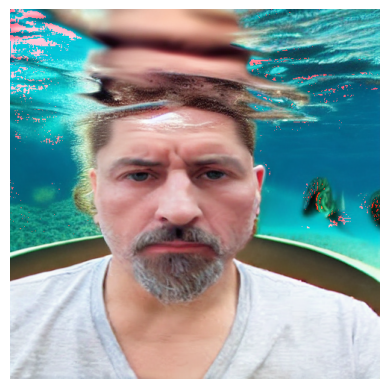

In [108]:

# Example usage of the function
generate_and_save_image(
    pipeline=pipe,
    prompt="underwater in the ocean",
    output_file="chrissy_underwater.png",
    num_steps=20,
    generator=generator,
    eta=1.0,
    init_image_file="sad_chrissy.jpg",
    mask_image_file="sad_chrissy_mask.jpg",
    image_size=(500, 500)
)

  0%|          | 0/20 [00:00<?, ?it/s]

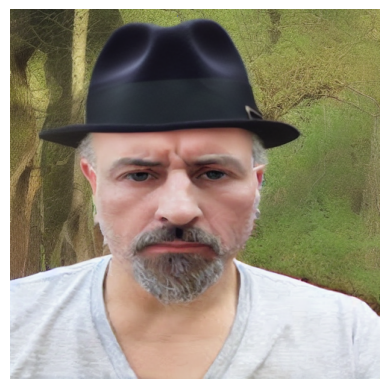

In [109]:

# Example usage of the function
generate_and_save_image(
    pipeline=pipe,
    prompt="wearing a fedora",
    output_file="chrissy_in_a_hat.png",
    num_steps=20,
    generator=generator,
    eta=1.0,
    init_image_file="sad_chrissy.jpg",
    mask_image_file="sad_chrissy_mask.jpg",
    image_size=(500, 500)
)

  0%|          | 0/20 [00:00<?, ?it/s]

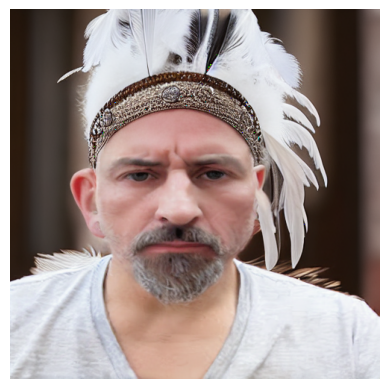

In [131]:

# Example usage of the function
generate_and_save_image(
    pipeline=pipe,
    prompt="feather headdress",
    output_file="chrissy_and_swans.png",
    num_steps=20,
    generator=generator,
    eta=1.0,
    init_image_file="sad_chrissy.jpg",
    mask_image_file="sad_chrissy_mask.jpg",
    image_size=(500, 500)
)